In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sns
from util import sample_2d_dist
from made import MADE
from ar_mlp import MLP_autoreg


%load_ext autoreload
%autoreload 2
%matplotlib inline

# Data distribution

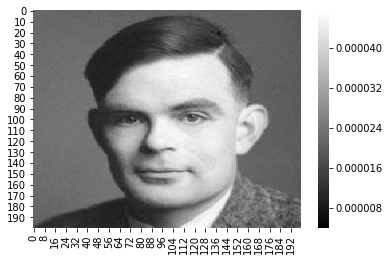

In [2]:
np.random.seed(42)

pdf_gt = np.load('distribution.npy')
sns.heatmap(pdf_gt, cmap='gray')

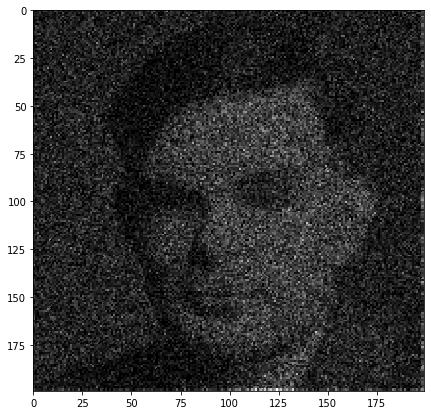

In [3]:
# sample datasets
n_samples = 100000
n_train = int(.8 * n_samples)
data = sample_2d_dist(n_samples, pdf_gt).astype(float)
train_data = data[:n_train]
test_data = data[n_train:]
valid_data = sample_2d_dist(10000, pdf_gt)

plt.figure(figsize=(7,7))
_ = plt.hist2d(data[:, 1], data[:, 0], bins=np.arange(len(pdf_gt)), cmap='gray')
plt.gca().invert_yaxis()

# Train Models

In [4]:
from torch.utils.data import DataLoader


def train(model, train_data, val_data=None, n_epochs=100, learning_rate=1e-3, batch_size=100):
#     device = torch.device("cpu")
    device = torch.device("cuda:0") # Uncomment this to run on GPU
    model.to(device)
    train_loader = DataLoader(torch.tensor(train_data, dtype=torch.float32), batch_size=batch_size)
    val_data = torch.tensor(val_data, device=device, dtype=torch.float32)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_logliks = []
    valid_logliks = []
    valid_t = []
    for t in range(n_epochs):
        if val_data is not None:
            with torch.no_grad():
                tmp = model(val_data) / np.log(2) / val_data.shape[1]
                valid_logliks.append(torch.mean(-tmp))
                valid_t.append(t*len(train_loader))
        for i, x in enumerate(train_loader):
            x = x.to(device)
            # compute likelihood
            logprob = model(x)
            loss = torch.mean(-logprob)
            # record likelihood in units of bits
            with torch.no_grad():
                train_logliks.append(loss / np.log(2) / x.shape[1])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return train_logliks, (valid_t, valid_logliks)
        

## MLP model

In [5]:
from torch.utils.data import DataLoader

# hyperparameters
learning_rate = 1e-2
batch_size = 100
n_epochs = 10

# train MLP
n_hidden = 20
mlp_model = MLP_autoreg(pdf_gt.shape, n_hidden, one_hot=True)
loglik_train, (t_val, loglik_val) = train(mlp_model, train_data, val_data=valid_data,
                                          n_epochs=n_epochs, learning_rate=learning_rate,
                                          batch_size=batch_size)

Likelihood of validation set (uniform distribution): 7.643856189774724
Likelihood of validation set (model): 7.622095108032227
Likelihood of validation set (true distribution): 7.588924884796143
Likelihood of test set (model): 7.618356073175438
Likelihood of test set (true distribution): 7.588040828704834


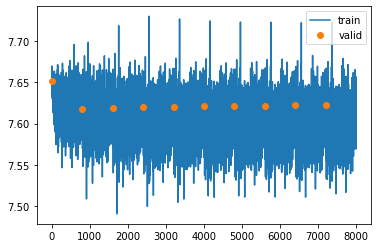

In [6]:
plt.figure()
plt.plot(loglik_train, label='train')
plt.plot(t_val, loglik_val, 'o', label='valid')

print('Likelihood of validation set (uniform distribution): {}'.format(-.5*np.log2(1/200**2)))
print('Likelihood of validation set (model): {}'.format(loglik_val[-1]))
print('Likelihood of validation set (true distribution): {}'.format(
    np.mean(-.5*np.log2(pdf_gt[valid_data.astype(int)[:,0], valid_data.astype(int)[:, 1]])))
    )
# plt.ylim([7.475, 7.8])
plt.legend()

with torch.no_grad():
    mlp_model.to('cpu')
    test_loglik = np.mean(-mlp_model(torch.tensor(test_data, dtype=torch.float32)).numpy()) / np.log(2) / 2.
print('Likelihood of test set (model): {}'.format(test_loglik))
print('Likelihood of test set (true distribution): {}'.format(
    np.mean(-.5*np.log2(pdf_gt[test_data.astype(int)[:,0], test_data.astype(int)[:, 1]]))))

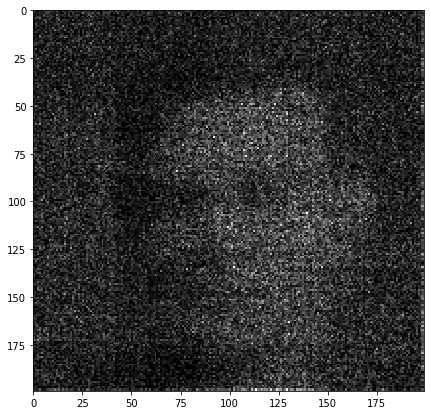

In [7]:
# generate samples
mlp_model.to('cpu')
samples = mlp_model.sample(100000).squeeze()
# print(samples.shape)
plt.figure(figsize=(7,7))
_ = plt.hist2d(samples[:, 1], samples[:, 0], bins=np.arange(len(pdf_gt)), cmap='gray')
plt.gca().invert_yaxis()

Observation: Overfitting to the training data actually yields better looking samples.
I managed to overfit only with one-hot encoding.

## MADE

In [7]:
# hyperparameters
learning_rate = 1e-3
batch_size = 100
n_epochs = 5

# train MLP
hidden_dims = [100, 100]
made_model = MADE(pdf_gt.shape, hidden_dims, n_masks=5)
loglik_train, (t_val, loglik_val) = train(made_model, train_data, val_data=valid_data,
                                          n_epochs=n_epochs, learning_rate=learning_rate,
                                          batch_size=batch_size)

Likelihood of validation set (uniform distribution): 7.643856189774724
Likelihood of validation set (model): 7.617549896240234
Likelihood of validation set (true distribution): 7.58766508102417
Likelihood of test set (model): 7.614549065215939
Likelihood of test set (true distribution): 7.588040828704834


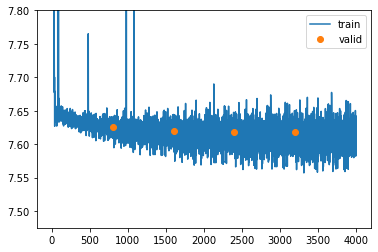

In [8]:
plt.figure()
plt.plot(loglik_train, label='train')
plt.plot(t_val, loglik_val, 'o', label='valid')

print('Likelihood of validation set (uniform distribution): {}'.format(-.5*np.log2(1/200**2)))
print('Likelihood of validation set (model): {}'.format(loglik_val[-1]))
print('Likelihood of validation set (true distribution): {}'.format(
    np.mean(-.5*np.log2(pdf_gt[train_data.astype(int)[:,0], train_data.astype(int)[:, 1]])))
    )
plt.ylim([7.475, 7.8])
plt.legend()

with torch.no_grad():
    made_model.to('cpu')
    test_loglik = np.mean(-made_model(torch.tensor(test_data, dtype=torch.float32)).numpy()) / np.log(2) / 2.
print('Likelihood of test set (model): {}'.format(test_loglik))
print('Likelihood of test set (true distribution): {}'.format(
    np.mean(-.5*np.log2(pdf_gt[test_data.astype(int)[:,0], test_data.astype(int)[:, 1]]))))


[1 0]
[1 0]
[1 0]
[1 0]
[0 1]


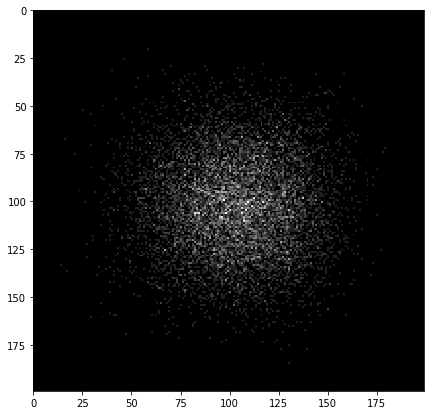

In [9]:
made_model.to('cpu')
samples = made_model.sample(10000).squeeze()
# print(samples.shape)
plt.figure(figsize=(7,7))
_ = plt.hist2d(samples[:, 1], samples[:, 0], bins=np.arange(len(pdf_gt)), cmap='gray')
plt.gca().invert_yaxis()


In [10]:
print('Likelihood of samples (true distribution): {}'.format(
    np.mean(-.5*np.log2(pdf_gt[samples.astype(int)[:,0], samples.astype(int)[:, 1]])))
    )


Likelihood of samples (true distribution): 7.438576698303223


Implementation does not work if more than one mask is used. Or does it???? (see likelihood of samples)